In [115]:
from massa_mola_2_corpos.dataset import get_position_and_force, build_dataset, k_matrix, c_matrix, m_matrix
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

$\ddot{q} = M^{-1}(f - Kq - C\dot{q}) - g $

In [150]:
dt = 0.001
k = [2, 2]
m = [10, 15]
c = [9, 7]
pos, force = get_position_and_force(dt=dt, k=k, m=m, c=c, steps=50000)

100%|██████████| 50000/50000 [00:55<00:00, 907.86it/s] 


In [151]:
pos

array([[ 0.00000000e+00,  1.00000000e+00],
       [-5.00348960e-06,  9.99995028e-01],
       [-2.00079168e-05,  9.99980113e-01],
       ...,
       [ 2.47048199e+01, -4.86159964e+01],
       [ 2.47044159e+01, -4.86160650e+01],
       [ 2.47040120e+01, -4.86161338e+01]])

In [152]:
def add_noise(x, scale=0.05):
    return scale*np.random.normal(size=x.shape)

In [153]:
q, q_dot, q_dot2, f = build_dataset(pos, force, dt=dt)


#pos += add_noise(pos, scale=0.01)
qn, q_dotn, q_dot2n, fn = build_dataset(pos + add_noise(pos, scale=0.05), force, dt=dt)
#q += add_noise(q)
#q_dot += add_noise(q_dot)
#q_dot2 += add_noise(q_dot2)

f = f.reshape((-1, 1))


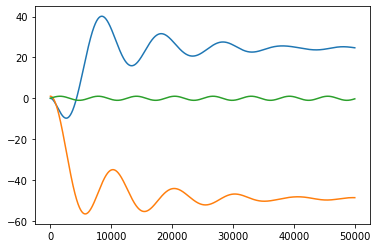

In [154]:

plt.plot(q)
#plt.plot(q_dot)
#plt.plot(q_dot2)
plt.plot(f)
plt.show()

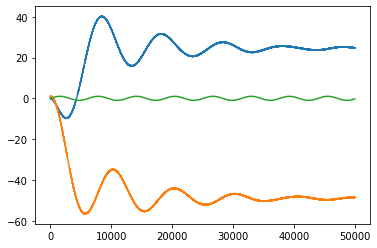

In [155]:

plt.plot(qn)
#plt.plot(q_dot)
#plt.plot(q_dot2)
plt.plot(f)
plt.show()

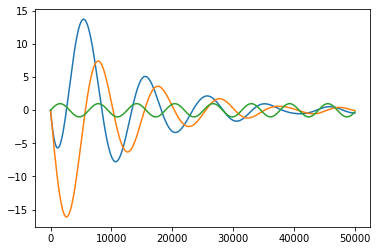

In [156]:
plt.plot(q_dot)
plt.plot(f)
plt.show()

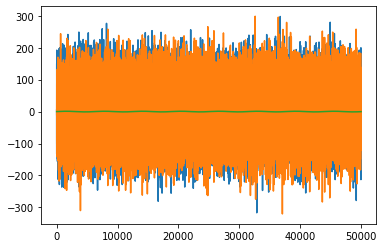

In [157]:
plt.plot(q_dotn)
plt.plot(fn)
plt.show()

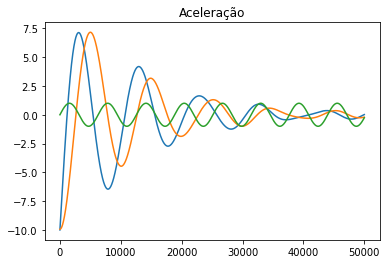

In [158]:
plt.plot(q_dot2)
plt.plot(f)
plt.title("Aceleração")
plt.show()

In [159]:
# Filter

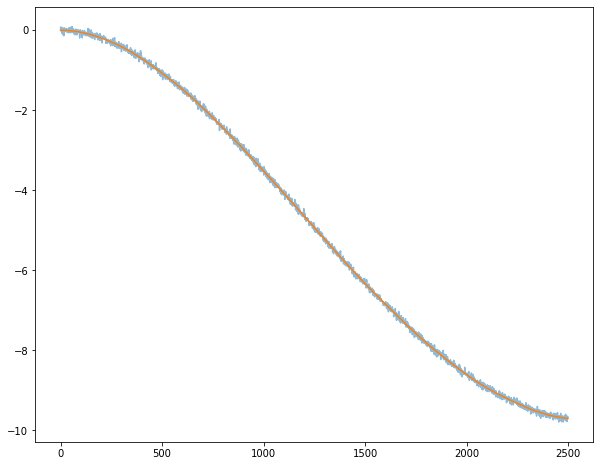

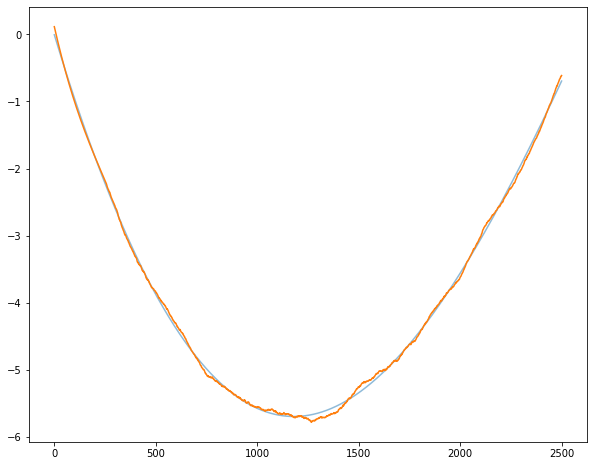

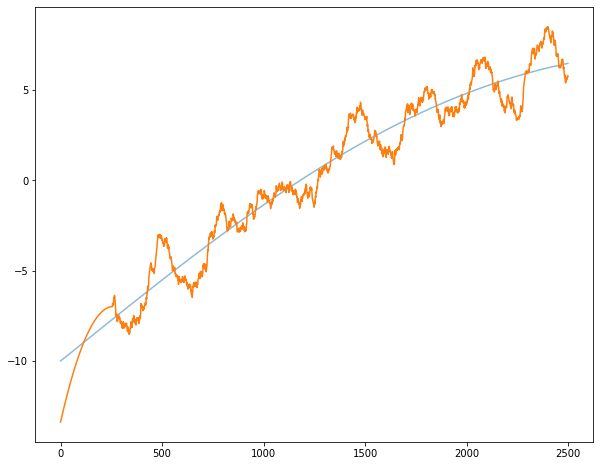

In [160]:
from scipy.signal import savgol_filter

x = qn[:,0]

x_smooth = savgol_filter(x, window_length = 511, polyorder = 4, deriv=0)
dx = savgol_filter(x, window_length = 511, polyorder = 4, deriv=1)
ddx = savgol_filter(x, window_length = 511, polyorder = 4, deriv=2)

plt.figure(figsize=(10,8))
plt.plot(x[:2500], alpha=0.5)
plt.plot(x_smooth[:2500])
#plt.plot(dx)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(q_dot[:2500, 0], alpha=0.5)
plt.plot(dx[:2500]/dt)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(q_dot2[:2500, 0], alpha=0.5)
plt.plot(ddx[:2500]/(dt**2))
plt.show()

In [161]:
from jax.experimental.stax import Dense, serial
import jax
import jax.numpy as jnp
import numpy as onp
from jax import grad, jit, vmap, value_and_grad, jacfwd, jacrev, jacobian, hessian
from jax import random
from jax.experimental import stax
from jax.experimental.optimizers import adam, sgd
from functools import partial
# Generate key which is used to generate random numbers
rng = random.PRNGKey(2211230)

In [162]:
"""

Utils

"""


def mse(y_true, y_pred):
    
    assert(jnp.squeeze(y_true).shape == jnp.squeeze(y_pred).shape)
    diff = jnp.squeeze(y_true) - np.squeeze(y_pred)
    return jnp.mean(jnp.square(diff))

"""

Modelo Físico

"""

def initialize_params(rng, dims):
    """ Inicializa massa k e c """
    keys = random.split(rng, 3)
    params = [random.normal(keys[i], [dims, dims]) for i in range(2)]
    return params
    
def forward_pass(params, q, q_dot, f, mass= jnp.array([[1, 0], [0, 1]])):
    """ 
    Uma instancia de x é do formato [x, x_dot] 
    Um forward pass estima a aceleração do sistema

    """
    q = q.reshape((-1, 1))
    q_dot = q_dot.reshape((-1, 1))
    f = f.reshape((-1, 1))
    M_inv = np.linalg.pinv(mass)
    C = params[1] @ q_dot 
    K = params[0] @ q
    return jnp.squeeze(M_inv @ (f - C - K) - 9.81, -1)

forward_pass = partial(forward_pass, mass=jnp.array(m_matrix(m)))
batch_forward_pass = vmap(forward_pass, in_axes=(None, 0, 0, 0), out_axes=0)


@jit
def loss(params, q, q_dot, q_dot2, f):
    pred = batch_forward_pass(params, q, q_dot, f)
    return mse(q_dot2, pred)


params = initialize_params(rng, dims=2)

In [163]:
params[1]

DeviceArray([[-0.30820706,  0.687614  ],
             [-0.07605282,  0.6251109 ]], dtype=float32)

In [164]:
f

array([[ 0.001     ],
       [ 0.002     ],
       [ 0.003     ],
       ...,
       [-0.26526856],
       [-0.26430425],
       [-0.2633397 ]], dtype=float32)

In [165]:
forward_pass(params, q[0], q_dot[0], f[0])

batch_forward_pass(params, q, q_dot, f)

loss(params, q, q_dot, q_dot2, f)

DeviceArray(75.41588, dtype=float32)

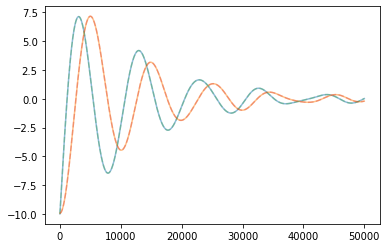

In [166]:
true_params = [k_matrix(k), c_matrix(c)]
pred = batch_forward_pass(true_params, q, q_dot, f)
plt.plot(q_dot2, alpha=0.5)
plt.plot(pred, alpha=0.3, linestyle="dashed")


In [167]:
q[0]

array([-5.0034896e-06,  9.9999505e-01], dtype=float32)

In [168]:
true_params[0] @ q[100].reshape((-1, 1))

array([[1.89861655],
       [1.99761548]])

In [169]:
q_dot

array([[-0.00500349, -0.00497166],
       [-0.01500443, -0.01491496],
       [-0.0249963 , -0.02485821],
       ...,
       [-0.404021  , -0.0681678 ],
       [-0.40400574, -0.06837601],
       [-0.40399024, -0.06858409]], dtype=float32)

# Treinamento

In [170]:
indexes = [i for i in range(len(q))]
np.random.shuffle(indexes)

q = q[indexes]
q_dot = q_dot[indexes]
q_dot2 = q_dot2[indexes]
f = f[indexes]
    
undo_shuffle = onp.argsort(indexes)

Epoch 0



Epoch 0 , mean error: 1.3202664 params: [DeviceArray([[ 0.30028993,  2.1592307 ],
             [-2.4303203 ,  1.7709204 ]], dtype=float32), DeviceArray([[ 2.322099 ,  6.508429 ],
             [-7.459847 ,  7.7023063]], dtype=float32)]


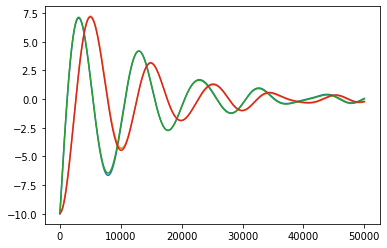

Epoch 1



Epoch 1 , mean error: 0.0038102707 params: [DeviceArray([[ 0.19241685,  2.1016948 ],
             [-2.3483489 ,  1.8144062 ]], dtype=float32), DeviceArray([[ 2.2076612,  6.685182 ],
             [-7.3718944,  7.569006 ]], dtype=float32)]


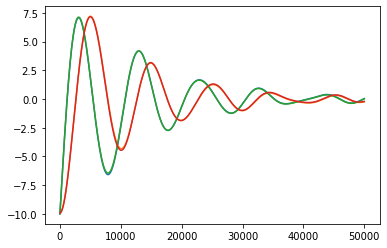

Epoch 2



Epoch 2 , mean error: 0.001950811 params: [DeviceArray([[ 0.11156842,  2.0588715 ],
             [-2.2694626 ,  1.856465  ]], dtype=float32), DeviceArray([[ 2.1216326,  6.817266 ],
             [-7.287187 ,  7.4404883]], dtype=float32)]


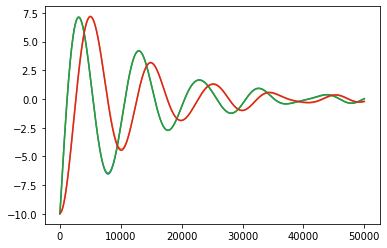

Epoch 3


KeyboardInterrupt: 

In [171]:
step_size = 1e-1
batch_size = 128
epochs = 10
init_fun, opt_update, get_params = adam(step_size=step_size)

params = initialize_params(rng, dims=2)
opt_state = init_fun(params)



def train_step(q, q_dot, q_dot2, f, opt_state, opt_update):
    params = get_params(opt_state)
    mse, grad = value_and_grad(loss)(params, q, q_dot, q_dot2, f)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state, mse


#def train_epoch(batch_size, q, q_dot, q_dot2, f, opt_state, opt_update):

epoch_errors = []
params_history = []
for epoch in range(epochs):

    n_batchs = len(q)//batch_size
    errors = []


    print("Epoch", epoch)
    for i in tqdm(range(n_batchs)):
        q_batch      = jnp.array(q[i*batch_size:((i+1)*batch_size)])
        q_dot_batch  = jnp.array(q_dot[i*batch_size:((i+1)*batch_size)])
        q_dot2_batch = jnp.array(q_dot2[i*batch_size:((i+1)*batch_size)])
        f_batch = jnp.array(f[i*batch_size:((i+1)*batch_size)])
        params, opt_state, error = train_step(q_batch, q_dot_batch, q_dot2_batch, f_batch, opt_state, opt_update)
        errors.append(error)
        params_history.append(params.copy())

    mean_error = np.mean(np.array(errors))
    print("Epoch", epoch, ", mean error:",mean_error, "params:", params)
    epoch_errors.append(mean_error)

    y_pred = np.array(batch_forward_pass(params, q, q_dot, f))
    plt.plot(np.squeeze(y_pred)[undo_shuffle])
    plt.plot(np.squeeze(q_dot2)[undo_shuffle])
    plt.show()



In [138]:
params_history = np.array(params_history)

In [139]:
params_history.shape

(3900, 2, 2, 2)

In [140]:
params_history[:, 0]

array([[[-0.7630825 , -0.4782476 ],
        [ 0.10764129,  1.0427113 ]],

       [[-0.8971928 , -0.3441586 ],
        [-0.02641572,  1.1768203 ]],

       [[-1.0519829 , -0.18881892],
        [-0.18129964,  1.3319821 ]],

       ...,

       [[-0.00286737,  1.9985005 ],
        [-1.9981431 ,  2.0009665 ]],

       [[-0.00286554,  1.9985058 ],
        [-1.9981452 ,  2.0009627 ]],

       [[-0.00285915,  1.9985083 ],
        [-1.9981494 ,  2.0009606 ]]], dtype=float32)

In [141]:
params_history[0][0]

array([[-0.7630825 , -0.4782476 ],
       [ 0.10764129,  1.0427113 ]], dtype=float32)

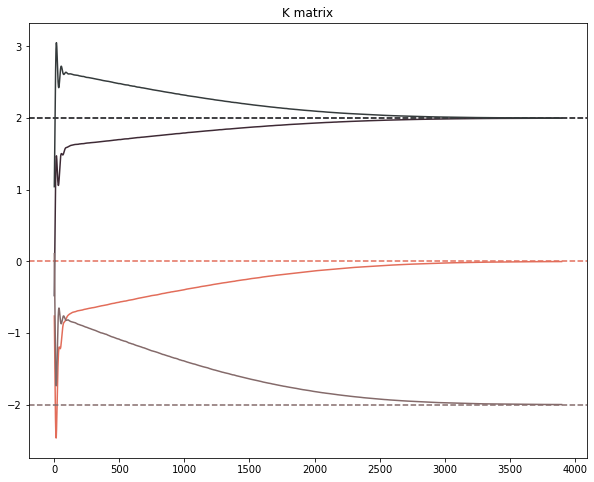

In [142]:
param_index = 0
colors = ["#E26D5A", "#3E2A35", "#846a6a", "#353b3c"]
K = params_history[:, param_index].reshape((-1, 4))

plt.figure(figsize=(10,8))
plt.title("K matrix")
for i in range(4):
    plt.plot(K[:, i], color=colors[i])
    plt.axhline(true_params[param_index].flatten()[i], color=colors[i], linestyle="dashed")

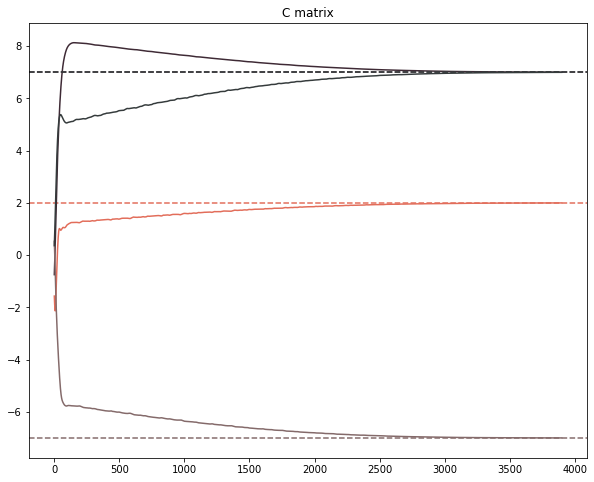

In [143]:
param_index = 1
colors = ["#E26D5A", "#3E2A35", "#846a6a", "#353b3c"]
K = params_history[:, param_index].reshape((-1, 4))

plt.figure(figsize=(10,8))
plt.title("C matrix")
for i in range(4):
    plt.plot(K[:, i], color=colors[i])
    plt.axhline(true_params[param_index].flatten()[i], color=colors[i], linestyle="dashed")